In [50]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#data processing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
import xgboost as xgb
from catboost import CatBoostClassifier

#Evaluation metrics
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Other packages
from joblib import dump
import os

In [51]:
train_final=pd.read_csv('final_train.csv')

In [52]:
train_final.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,DAKAR,Long-term,20000.000000,47.000000,21602.000000,7201.000000,52.000000,8835.000000,3391.000000,396.000000,185.000000,8.167483,7.709844,NO,62,voice,30.000000,0
1,DAKAR,Long-term,5529.210895,11.523756,5506.050798,1835.355961,13.974439,3368.801722,277.065798,95.160804,23.105018,8.167483,7.709844,NO,3,voice,9.262446,0
2,DAKAR,Long-term,5529.210895,11.523756,5506.050798,1835.355961,13.974439,3368.801722,277.065798,95.160804,23.105018,8.167483,7.709844,NO,1,voice,9.262446,0
3,SAINT-LOUIS,Long-term,7900.000000,19.000000,7896.000000,2632.000000,25.000000,9385.000000,27.000000,46.000000,20.000000,8.167483,2.000000,NO,61,data,7.000000,0
4,DAKAR,Long-term,12350.000000,21.000000,12351.000000,4117.000000,29.000000,9360.000000,66.000000,102.000000,34.000000,8.167483,7.709844,NO,56,voice,11.000000,0


In [53]:
train_final.isnull().sum()

REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
MRG               0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

Ploting Correlation graph to see which columns are more related to the target variable

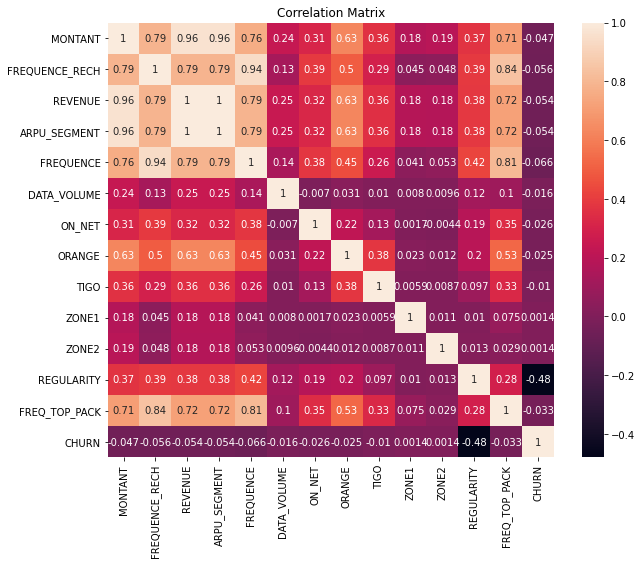

In [54]:
# Calculate correlation matrix
correl =train_final.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correl, annot=True)
plt.title('Correlation Matrix')
plt.show()

<AxesSubplot:>

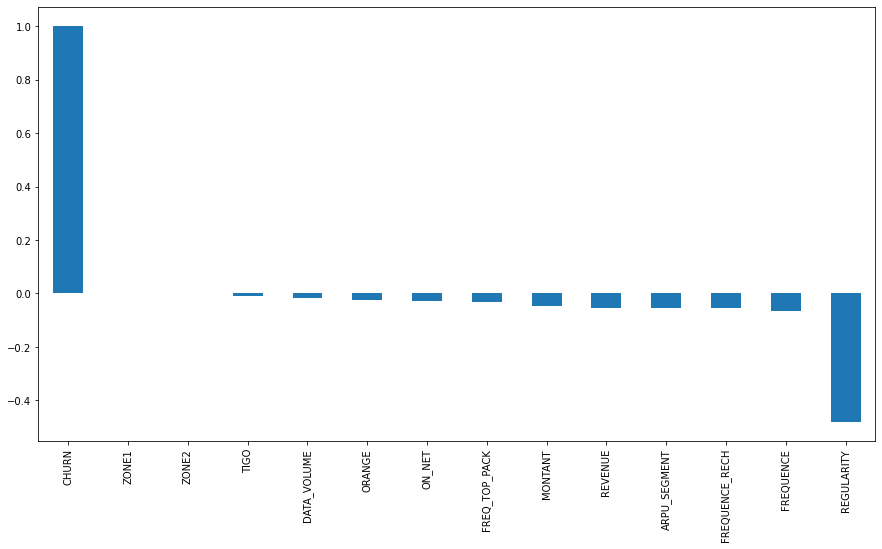

In [55]:
#Checking the Correlation of "Churn" with other variables in the dataset:
plt.figure(figsize=(15,8))
train_final.corr()['CHURN'].sort_values(ascending = False).plot(kind='bar')

In [56]:
train_final.drop(["MRG"],axis=1, inplace=True)

## Feature Engineering

In [57]:
#splitting data into train and validation data
X_train,X_validation,y_train,y_validation = train_test_split(train_final.iloc[:, :-1], train_final.iloc[:, -1:],
                                                    test_size=0.2, random_state=42, stratify=train_final.iloc[:, -1:])

In [58]:
X_train.shape,X_validation.shape,y_train.shape,y_validation.shape

((861619, 16), (215405, 16), (861619, 1), (215405, 1))

In [59]:
#Checking for duplicates in the dataset
train_duplicate = X_train.duplicated()
validation_duplicate =X_validation.duplicated()
print("Number of train duplicates: ", train_duplicate.sum())
print("Number of validation duplicate: ",validation_duplicate.sum())

Number of train duplicates:  255567
Number of validation duplicate:  60461


In [60]:
# Removing duplicates and keeping the first instance
X_train = X_train.drop_duplicates(keep='first')
y_train = y_train[train_duplicate == False]

X_validation = X_validation.drop_duplicates(keep='first')
y_validation = y_validation[validation_duplicate == False]

# Checking for duplicates in the filtered datasets
train_duplicates_remaining = X_train.duplicated().sum()
validation_duplicates_remaining = X_validation.duplicated().sum()


In [61]:
print("Number duplicates in the train dataset: ", train_duplicates_remaining)
print("Number duplicates in the validation dataset:  ", validation_duplicates_remaining)

Number duplicates in the train dataset:  0
Number duplicates in the validation dataset:   0


In [62]:
# Check for missing values in data
train_missing_values = X_train.isnull().sum()
print("missing values in train data: ", train_missing_values)

missing values in train data:  REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64


This was expected because the dataset has been cleaned in the other notebook

In [63]:
validation_missing_values = X_validation.isnull().sum()
print("the missing values in the validation set is :",validation_missing_values)

the missing values in the validation set is : REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64


## Encoding both the categorical variable and the target variable

In [64]:
#making a list of the numerical features
num_columns = [col for col in X_train.columns if X_train[col].dtype != 'object']

In [65]:
#imputing missing values
numerical_imputer= SimpleImputer(strategy= "median")

In [66]:
#transforming
X_train_imputed = numerical_imputer.fit_transform(X_train[num_columns])
X_eval_imputed = numerical_imputer.transform(X_validation[num_columns])

In [67]:
#list of the catehorical features
cat_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [68]:
cat_imputer = SimpleImputer(strategy= "most_frequent")

In [69]:
#transform
X_train_cat_imputed = cat_imputer.fit_transform(X_train[cat_columns])
X_eval_cat_imputed = cat_imputer.transform(X_validation[cat_columns])

In [70]:
#instanciating the onehotencoder
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded =pd.DataFrame(encoder.fit_transform(X_train_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names_out(cat_columns))

X_validation_encoded =pd.DataFrame(encoder.transform(X_eval_cat_imputed).toarray(),
                                   columns=encoder.get_feature_names_out(cat_columns))

## Feature scalling

In [71]:
# instanciating the scaler
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed),columns =num_columns)
X_validation_scaled = pd.DataFrame(scaler.transform(X_eval_imputed),columns =num_columns)

**Joining the dataframe**

In [72]:
Xtrain_final = pd.concat([X_train_scaled, X_train_encoded], axis=1)

Xeval_final = pd.concat([X_validation_scaled, X_validation_encoded], axis=1)

In [73]:
Xtrain_final.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_VAS,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_voice
0,0.011722,0.080952,0.010344,0.010346,0.144160,0.002491,0.005453,0.007904,0.005535,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.011235,0.092308,0.009961,0.009961,0.177778,0.006189,0.005453,0.000332,0.000000,0.003258,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.001021,0.000000,0.000938,0.000941,0.000000,0.000101,0.000197,0.000581,0.005535,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.010596,0.061538,0.009394,0.009397,0.088889,0.002491,0.005491,0.002907,0.003594,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.011722,0.080952,0.000036,0.000039,0.000000,0.002491,0.005453,0.000000,0.005535,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
Xeval_final.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,TENURE_Mid-term,TENURE_Short-term,TENURE_Very short-term,TOP_PACK_VAS,TOP_PACK_data,TOP_PACK_international,TOP_PACK_messaging,TOP_PACK_other_services,TOP_PACK_social_media,TOP_PACK_voice
0,0.000383,0.000000,0.010344,0.010346,0.144160,0.002491,0.005453,0.007904,0.005535,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.011722,0.080952,0.010344,0.010346,0.144160,0.002491,0.005453,0.007904,0.005535,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.032938,0.146154,0.027241,0.027245,0.311111,0.002491,0.006141,0.008970,0.015812,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.002511,0.038462,0.002255,0.002255,0.177778,0.002491,0.000236,0.000332,0.000000,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.006553,0.061538,0.005820,0.005823,0.100000,0.002491,0.001397,0.004070,0.003594,0.003258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [75]:
Xtrain_final.isnull().sum()

MONTANT                    0
FREQUENCE_RECH             0
REVENUE                    0
ARPU_SEGMENT               0
FREQUENCE                  0
DATA_VOLUME                0
ON_NET                     0
ORANGE                     0
TIGO                       0
ZONE1                      0
ZONE2                      0
REGULARITY                 0
FREQ_TOP_PACK              0
REGION_DAKAR               0
REGION_DIOURBEL            0
REGION_FATICK              0
REGION_KAFFRINE            0
REGION_KAOLACK             0
REGION_KEDOUGOU            0
REGION_KOLDA               0
REGION_LOUGA               0
REGION_MATAM               0
REGION_SAINT-LOUIS         0
REGION_SEDHIOU             0
REGION_TAMBACOUNDA         0
REGION_THIES               0
REGION_ZIGUINCHOR          0
TENURE_Long-term           0
TENURE_Medium-term         0
TENURE_Mid-term            0
TENURE_Short-term          0
TENURE_Very short-term     0
TOP_PACK_VAS               0
TOP_PACK_data              0
TOP_PACK_inter

**Checking the shape for the train and Eval set**

In [76]:
Xtrain_final.shape,Xeval_final.shape

((606052, 39), (154944, 39))

## Machine Learning Model 
### In this section of the notebook, we are training machine learning models with the prepared dataset

## Evaluation
**As per the requirement of the challeng, we will the Area Under the Curve (AUC) measure to evaluate the performance of the model**

### Model 1: RandomForestClassifier

In [78]:
rf_model =  RandomForestClassifier(random_state =42)
rf_model.fit(Xtrain_final,y_train)

RandomForestClassifier(random_state=42)

In [79]:
# making prediction
rf_probabilities = rf_model.predict_proba(Xeval_final)
rf_preds = rf_model.predict(Xeval_final)

**Evaluation of the model performance**

In [80]:
# Calculate the ROC AUC score
rf_auc_score = roc_auc_score(y_validation,rf_preds)

# Calculate the log loss
rf_logloss = log_loss(y_validation,rf_probabilities)

In [81]:
print('The models AUC_score is: ',rf_auc_score)
print('The models probability is: ',rf_logloss)

The models AUC_score is:  0.5766027864341654
The models probability is:  0.25410922248016277


## Model 2: GaussianNB

In [82]:
gaussian_model = GaussianNB()
gaussian_model.fit(Xtrain_final,y_train)

GaussianNB()

In [83]:
# making prediction
gaussian_probabilities = gaussian_model.predict_proba(Xeval_final)
gaussian_preds = gaussian_model.predict(Xeval_final)

**Evaluation of the model performance**

In [84]:
# Calculate the ROC AUC score
gaussian_auc_score = roc_auc_score(y_validation,gaussian_preds)

# Calculate the log loss
gaussian_logloss = log_loss(y_validation,gaussian_probabilities)

In [85]:
print('The models AUC_score is: ',gaussian_auc_score)
print('The models probability is: ',gaussian_logloss)

The models AUC_score is:  0.7426123992569164
The models probability is:  5.955073178781519


## Model 3: ComplementNB

In [86]:
cnb_model = ComplementNB()
cnb_model.fit(Xtrain_final,y_train)

ComplementNB()

In [87]:
# making prediction
cnb_probabilities = cnb_model.predict_proba(Xeval_final)
cnb_preds = cnb_model.predict(Xeval_final)

**Evaluation of the model performance**

In [88]:
#Evaluationg model performance
# Calculate the ROC AUC score
cnb_auc_score = roc_auc_score(y_validation,cnb_preds)

# Calculate the log loss
cnb_logloss = log_loss(y_validation,cnb_probabilities)

In [89]:
print('The models AUC_score is: ',cnb_auc_score)
print('The models probability is: ',cnb_logloss)

The models AUC_score is:  0.7577022888658804
The models probability is:  0.5188709884069475


## Model 4: logistic regression

In [90]:
lr_model = LogisticRegression()
lr_model.fit(Xtrain_final, y_train)

LogisticRegression()

In [91]:
# making prediction
lr_probabilities = lr_model.predict_proba(Xeval_final)
lr_preds = lr_model.predict(Xeval_final)

**Evaluation of the model performance**

In [92]:
#Evaluationg model performance
# Calculate the ROC AUC score
lr_auc_score = roc_auc_score(y_validation,lr_preds)

# Calculate the log loss
lr_logloss = log_loss(y_validation,lr_probabilities)

In [93]:
print('The models AUC_score is: ',lr_auc_score)
print('The models probability is: ',lr_logloss)

The models AUC_score is:  0.5033405524732764
The models probability is:  0.16424240873048512


## Model 5: ADA BOOST

In [94]:
Ada_model = AdaBoostClassifier()
Ada_model.fit(Xtrain_final,y_train)

AdaBoostClassifier()

In [95]:
# making prediction
ada_probabilities = Ada_model.predict_proba(Xeval_final)
ada_preds = Ada_model.predict(Xeval_final)

**Evaluation of the model performance**

In [96]:
#Evaluationg model performance
# Calculate the ROC AUC score
ada_auc_score = roc_auc_score(y_validation,ada_preds)

# Calculate the log loss
ada_logloss = log_loss(y_validation,ada_probabilities)

In [97]:
print('The models AUC_score is: ',ada_auc_score)
print('The models probability is: ',ada_logloss)

The models AUC_score is:  0.5703216933460088
The models probability is:  0.6521593388615018


## Model 6: SVM

In [98]:
Svm_model= SVC(kernel='linear') 
Svm_model.fit(Xtrain_final,y_train)

SVC(kernel='linear')

In [99]:
# making prediction
#svm_probabilities = Svm_model.predict_proba(Xeval_final)
svm_preds = Svm_model.predict(Xeval_final)

**Evaluation of the model performance**

In [100]:
#Evaluationg model performance
# Calculate the ROC AUC score
svm_auc_score = roc_auc_score(y_validation,svm_preds)

# Calculate the log loss
#svm_logloss = log_loss(y_validation,svm_probabilities)

In [101]:
print('The models AUC_score is: ',svm_auc_score)
#print('The models probability is: ',svm_logloss)

The models AUC_score is:  0.5


## Comparison

In [102]:
results_table= {'models':['Random Forest','GaussianNB','AdaBoost','ComplementNB','Logistic Regression', 'SVM'],
         'AUC_score':[rf_auc_score,gaussian_auc_score,ada_auc_score,cnb_auc_score,lr_auc_score,svm_auc_score],
         'log_loss':[rf_logloss,gaussian_logloss,ada_logloss,cnb_logloss,lr_logloss, 'N/A']}
results_table= pd.DataFrame(results_table)

In [103]:
results_table.sort_values(by= 'AUC_score', ascending = False)

,models,AUC_score,log_loss
3,ComplementNB,0.757702,0.518871
1,GaussianNB,0.742612,5.955073
0,Random Forest,0.576603,0.254109
2,AdaBoost,0.570322,0.652159
4,Logistic Regression,0.503341,0.164242
5,SVM,0.500000,N/A


**Based on the results presented in the above table, we can conclude that Complement naive bayes is the best model among the six trained models. We however like to improve that particular model by balancing the dataset**

## Hyper-parameter tuning of the ComplementNB

In [104]:
train_final.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,DAKAR,Long-term,20000.000000,47.000000,21602.000000,7201.000000,52.000000,8835.000000,3391.000000,396.000000,185.000000,8.167483,7.709844,62,voice,30.000000,0
1,DAKAR,Long-term,5529.210895,11.523756,5506.050798,1835.355961,13.974439,3368.801722,277.065798,95.160804,23.105018,8.167483,7.709844,3,voice,9.262446,0
2,DAKAR,Long-term,5529.210895,11.523756,5506.050798,1835.355961,13.974439,3368.801722,277.065798,95.160804,23.105018,8.167483,7.709844,1,voice,9.262446,0
3,SAINT-LOUIS,Long-term,7900.000000,19.000000,7896.000000,2632.000000,25.000000,9385.000000,27.000000,46.000000,20.000000,8.167483,2.000000,61,data,7.000000,0
4,DAKAR,Long-term,12350.000000,21.000000,12351.000000,4117.000000,29.000000,9360.000000,66.000000,102.000000,34.000000,8.167483,7.709844,56,voice,11.000000,0


In [105]:
# Instantiate SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(Xtrain_final, y_train)

In [106]:
print("Class distribution after applying SMOTE:")
print(y_train_smote.value_counts())

Class distribution after applying SMOTE:
CHURN
0        571226
1        571226
dtype: int64


In [107]:
Xtrain_final.isnull().sum()

MONTANT                    0
FREQUENCE_RECH             0
REVENUE                    0
ARPU_SEGMENT               0
FREQUENCE                  0
DATA_VOLUME                0
ON_NET                     0
ORANGE                     0
TIGO                       0
ZONE1                      0
ZONE2                      0
REGULARITY                 0
FREQ_TOP_PACK              0
REGION_DAKAR               0
REGION_DIOURBEL            0
REGION_FATICK              0
REGION_KAFFRINE            0
REGION_KAOLACK             0
REGION_KEDOUGOU            0
REGION_KOLDA               0
REGION_LOUGA               0
REGION_MATAM               0
REGION_SAINT-LOUIS         0
REGION_SEDHIOU             0
REGION_TAMBACOUNDA         0
REGION_THIES               0
REGION_ZIGUINCHOR          0
TENURE_Long-term           0
TENURE_Medium-term         0
TENURE_Mid-term            0
TENURE_Short-term          0
TENURE_Very short-term     0
TOP_PACK_VAS               0
TOP_PACK_data              0
TOP_PACK_inter

## Model 1: Logistic Regression

In [108]:
#fitting logistic regression model with balanced data.
lr_smote_model = LogisticRegression()
lr_smote_model.fit(X_train_smote,y_train_smote)

LogisticRegression()

**Make predictions**

In [109]:
lr_smote_proba = lr_smote_model.predict_proba(Xeval_final)
lr_smote_preds = lr_smote_model.predict(Xeval_final)

In [110]:
# Calculate the ROC AUC score
lr_smote_auc_score = roc_auc_score(y_validation, lr_smote_preds)

# Calculate the log loss
lr_smote_logloss = log_loss(y_validation, lr_smote_proba)

**Print the results**

In [111]:
print('The model\'s AUC score is:', lr_smote_auc_score)
print('The model\'s log loss is:', lr_smote_logloss)

The model's AUC score is: 0.8079347033590937
The model's log loss is: 0.4511909588228589


## Model 2: ComplementNB

In [112]:
#fitting Complement naive bayes model with balanced data.
cnb_smote_model = ComplementNB()
cnb_smote_model.fit(X_train_smote,y_train_smote)

ComplementNB()

**Make predictions**

In [113]:
cnb_smote_proba = cnb_smote_model.predict_proba(Xeval_final)
cnb_smote_preds = cnb_smote_model.predict(Xeval_final)

In [114]:
# Calculate the ROC AUC score
cnb_smote_auc_score = roc_auc_score(y_validation, cnb_smote_preds)

# Calculate the log loss
cnb_smote_logloss = log_loss(y_validation, cnb_smote_proba)


**Print the results**

In [115]:
print('The model\'s AUC score is:', cnb_smote_auc_score)
print('The model\'s log loss is:', cnb_smote_logloss)

The model's AUC score is: 0.7576854656893081
The model's log loss is: 0.5181585137170527


## Model 3: GaussianNB

In [116]:
#fitting logistic regression model with balanced data.
gnb_smote_model =  GaussianNB()
gnb_smote_model.fit(X_train_smote,y_train_smote)

GaussianNB()

**Make predictions**

In [117]:
gnb_smote_proba = gnb_smote_model.predict_proba(Xeval_final)
gnb_smote_preds = gnb_smote_model.predict(Xeval_final)

In [118]:
# Calculate the ROC AUC score
gnb_smote_auc_score = roc_auc_score(y_validation, gnb_smote_preds)

# Calculate the log loss
gnb_smote_logloss = log_loss(y_validation, gnb_smote_proba)

In [119]:
print('The model\'s AUC score is:', gnb_smote_auc_score)
print('The model\'s log loss is:', gnb_smote_logloss)

The model's AUC score is: 0.739900904305255
The model's log loss is: 7.675727861034086


## Comparison table for the balanced dataset with SMOTE method

In [120]:
Smote_results_table= {'models':['Logistic Regression','ComplementNB','GaussianNB'],
         'AUC_score':[lr_smote_auc_score,cnb_smote_auc_score,cnb_smote_auc_score],
         'log_loss':[lr_logloss,cnb_smote_logloss,gnb_smote_logloss]}
Smote_results_table= pd.DataFrame(Smote_results_table)

In [121]:
Smote_results_table.sort_values(by= 'AUC_score', ascending = False)

,models,AUC_score,log_loss
0,Logistic Regression,0.807935,0.164242
1,ComplementNB,0.757685,0.518159
2,GaussianNB,0.757685,7.675728


## Saving key components in the current working directory

In [122]:
 # Get the current working directory
cwd = os.getcwd()

# Specify the relative path to the destination directory
destination = os.path.join(cwd, "key_comp")

# Create the "key_comp" directory if it doesn't exist
os.makedirs(destination, exist_ok=True)

# Export the imputer
num_imputer_filepath = os.path.join(destination, "numerical_imputer.joblib")
try:
    dump(numerical_imputer, num_imputer_filepath)
    print(f"Numerical Imputer exported to: {num_imputer_filepath}")
except Exception as e:
    print(f"Failed to export Numerical Imputer: {str(e)}")

cat_imputer_filepath = os.path.join(destination, "cat_imputer.joblib")
try:
    dump(cat_imputer, cat_imputer_filepath)
    print(f"Categorical Imputer exported to: {cat_imputer_filepath}")
except Exception as e:
    print(f"Failed to export Categorical Imputer: {str(e)}")

# Export the Encoder
encoder_filepath = os.path.join(destination, "encoder.joblib")
try:
    dump(encoder, encoder_filepath)
    print(f"Encoder exported to: {encoder_filepath}")
except Exception as e:
    print(f"Failed to export Encoder: {str(e)}")

# Export the scaler
scaler_filepath = os.path.join(destination, "scaler.joblib")
try:
    dump(scaler, scaler_filepath)
    print(f"Scaler exported to: {scaler_filepath}")
except Exception as e:
    print(f"Failed to export Scaler: {str(e)}")

# Export the models
lr_model_filepath = os.path.join(destination, "lr_smote_model.joblib")
try:
    dump(lr_smote_model, lr_model_filepath)
    print(f"Logistic Regression Model exported to: {lr_model_filepath}")
except Exception as e:
    print(f"Failed to export Logistic Regression Model: {str(e)}")

cnb_model_filepath = os.path.join(destination, "cnb_smote_model.joblib")
try:
    dump(cnb_smote_model, cnb_model_filepath)
    print(f"complementNB Model exported to: {cnb_model_filepath}")
except Exception as e:
    print(f"Failed to export complementNB Model: {str(e)}")


Numerical Imputer exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\numerical_imputer.joblib
Categorical Imputer exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\cat_imputer.joblib
Encoder exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\encoder.joblib
Scaler exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\scaler.joblib
Logistic Regression Model exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\lr_smote_model.joblib
complementNB Model exported to: C:\Users\user\Desktop\AZUBI AFRICA\SecondPhase\CapstoneProject\Notebook\key_comp\cnb_smote_model.joblib


**Here, we are going to encode all the numerical variables, drop the the target variable and train 3 to 5 models**